Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [71]:
NAME = "Rhugved Bhojane"
COLLABORATORS = "Rhugved Bhojane"

In [72]:
print(NAME)

Rhugved Bhojane


---

$$
\newcommand{\x}{\mathbf{x}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\price}{{p}}
\newcommand{\ret}{{r}}
\newcommand{\tp}{{(t)}}
\newcommand{\aapl}{{\text{AAPL}}}
\newcommand{\ba}{{\text{BA}}}
\newcommand{\spy}{{\text{SPY}}}
$$

# Assignment: Using Machine Learning for Hedging

Welcome to the first assignment !

# Problem description

We will solve a Regression task that is very common in Finance
- Given the return of "the market", predict the return of a particular stock

That is
- Given the return of a proxy for "the market" at time $t$, predict the return of, e.g., Apple at time $t$.

As we will explain,
being able to predict the relationship between two financial instruments opens up possibilities
- Use one instrument to "hedge" or reduce the risk of holding the other
- Create strategies whose returns are independent of "the market"
    - Hopefully make a profit regardless of whether the market goes up or down

## Goal

You will create models of increasing complexity in order to explain the return of Apple (ticker $\aapl$)
- The first model will have a single feature: return of the market proxy, ticker $\spy$
- Subsequent models will add the return of other tickers as additional features

## Learning Objectives
- Learn how to solve a Regression task
- Become facile in the `sklearn` toolkit for Machine Learning

## How to report your answers
We will mix explanation of the topic with tasks that you must complete. 

Look for 
the string "**Question**" to find a task that you must perform.

Most of the tasks will require you to create some code at the location indicated by

>`# YOUR CODE HERE
raise NotImplementedError()`

- Replace `raise NotImplementedError()` with your own code

# Standard imports

In [73]:
!pip install --upgrade scikit-learn

In [74]:
# Standard imports
!pip install numpy
!pip install pandas 
!pip install matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn

import os
import math

%matplotlib inline

In [75]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

# Import nn_helper module
import helper
%aimport helper

helper = helper.HELPER()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Get The data


The first step in our Recipe is Get the Data.

The data are the daily prices of a number of individual equities and equity indices.

The prices are arranged in a series in ascending date order (a timeseries).
- There are many `.csv` files for equity or index in the directory `DATA_DIR`

## API for students

We will define some utility routines to help you.

In this way, you can focus on the learning objectives rather than data manipulation.

This is not representative of the "real world"; you will need to complete data manipulation tasks in later assignments.

We provide a class `HELPER`
- Instantiated as 
>    `helper = helper.HELPER()`

With methods
- `getData`:
    - Get examples for a list of equity tickers and an index ticker.
    - Called as
    > `data = helper.getData( tickers, index_ticker, attrs)`
        - `tickers` is a list of tickers
        - `index` is the ticker of the index  
        - `attrs` is a list of data attributes
   

**Question:**
- Create code to
    - Get the adjusted close price of $\aapl$ and $\spy$ 
    - Assign the result to variable `data`

**Hint:**
- Use the `getData` method from the helper class
    - The list of tickers contains just the single ticker $\aapl$
    - The index ticker is $\spy$
    - The list of attributes is the single attribute `Adj Close`


In [76]:
ticker = "AAPL"
index_ticker = "SPY"
dateAttr = "Dt"
priceAttr = "Adj Close"

# YOUR CODE HERE
data = helper.getData([ticker], index_ticker, [priceAttr])

# Have a look at the data

We will not go through all steps in the Recipe, nor in depth.

But here's a peek at the data you retrieved

In [77]:
data.head()

,AAPL_Adj_Close,SPY_Adj_Close
Dt,,
2017-01-03,110.9539,213.8428
2017-01-04,110.8297,215.1149
2017-01-05,111.3933,214.9440
2017-01-06,112.6351,215.7131
2017-01-09,113.6668,215.0010


In [78]:
# Print the Start time and End time
print("Start time: ", data.index.min())
print("End time: ", data.index.max())

Start time:  2017-01-03
End time:  2019-10-31


## Create DataFrame of price levels for the training examples

The training examples will be stored in a DataFrame.

- The DataFrame should have two columns: the price level for the ticker and for the index
- The minimum date in the DataFrame should be **the trading day before** `start_dt`
    - That is: the latest date for which there is data and which is less than `start_dt`
    - For example, if `start_dt` is a Monday, the "day before" would be Friday, not Sunday.
        - Similarly for the case where the day before `start_dt` is a holiday
- The maximum date in the DataFrame should be `end_dt`

The reason we are adding one day prior to `start_dt`
- We want to have returns (percent price changes) from `start_dt` onwards
- In order to compute a return for `start_dt`, we need the level from the prior day

**Question:**

- Complete the function `getRange()`
    - To return the subset of rows of our examples
    - Beginning on the **trading day before** date `start_dt`
    - Ending on date `end_dt`


In [79]:
start_dt = "2018-01-02"
end_dt = "2018-09-28"
train_data_price = None

# Set variable train_data_price to be a DataFrame with two columns
## AAPL_Adj_Close, SPY_Adj_Close
## with dates as the index
## Having minimum date equal to THE DAY BEFORE start_dt
## Having maximum date equal to end_dt

def getRange(df, start_dt, end_dt):
    '''
    Return the the subset of rows of DataFrame df
    restricted to dates between start_dt and end_dt
    
    Parameters
    ----------
    df: DataFrame
    - The data from which we will take a subset
    
    start_dt: String
    - Start date
    
    end_dt: String
    - End date
    '''
    df.index = pd.to_datetime(df.index)
    start_dt = pd.to_datetime(start_dt)
    end_dt = pd.to_datetime(end_dt)
    data_before = df.loc[df.index < start_dt].index.max()
    df = df.loc[(df.index >= data_before) & (df.index <= end_dt)]
    return df

    

train_data_price = getRange(data, start_dt, end_dt)
print(train_data_price.head())

            AAPL_Adj_Close  SPY_Adj_Close
Dt                                       
2017-12-29        164.2589       258.2823
2018-01-02        167.1999       260.1310
2018-01-03        167.1708       261.7763
2018-01-04        167.9473       262.8796
2018-01-05        169.8594       264.6314


As you can see, each row has two attributes for one  date
- Price (adjusted close) of ticker $\aapl$
- Price (adjusted close) of the market proxy $\spy$

# Create test set

We just created a set of training examples as a subset of the rows of `data`.

We will do the same to create a set of test examples.

**Question:**

Set variable `test_data_price`
- To  the subset of rows of our examples
- Beginning on the **trading day before** date `test_start_dt`
- Ending on date `test_end_dt`

**Hint**
- Use `getRange` with different arguments for the dates

In [80]:
test_start_dt = '2018-10-01'
test_end_dt = '2018-12-31'

# YOUR CODE HERE
test_data_price = getRange(data, test_start_dt, test_end_dt)
#raise NotImplementedError()
print(test_data_price)


            AAPL_Adj_Close  SPY_Adj_Close
Dt                                       
2018-09-28        221.6252       285.0555
2018-10-01        223.1175       286.0458
2018-10-02        225.1006       285.8791
2018-10-03        227.8398       286.0359
2018-10-04        223.8342       283.8004
...                    ...            ...
2018-12-24        144.6565       231.1158
2018-12-26        154.8435       242.7929
2018-12-27        153.8386       244.6569
2018-12-28        153.9174       244.3412
2018-12-31        155.4050       246.4814

[64 rows x 2 columns]


# Prepare the data

In Finance, it is very typical to work with *relative changes* (e.g., percent price change)
rather than *absolute changes* (price change) or *levels* (prices).

Without going into too much detail
- Relative changes are more consistent over time than either absolute changes or levels
- The consistency can facilitate the use of data over a longer time period

For example, let's suppose that prices are given in units of USD (dollar)
- A price change of 1 USD is more likely for a stock with price level 100 than price level 10
    - A relative change of $1/100 = 1 %$ is more likely than a change of $1/10 = 10%$
    - So relative changes are less dependent on price level than either price changes or price levels
    
    
To compute the *return* (percent change in prices)
 for ticker $\aapl$ (Apple) on date $t$

$$
\begin{array}[lll]\\
\ret_\aapl^\tp = \frac{\price _\aapl^\tp}{\price _\aapl^{(t-1)}} -1 \\
\text{where} \\
\price_\aapl^\tp \text{ denotes the price of ticker } \aapl \text{ on date } t \\
\ret_\aapl^\tp \text{ denotes the return of ticker } \aapl \text{ on date } t
\end{array}
$$


# Transformations: transform the training data

Our first task is to transform the data from price levels (Adj Close)
to Percent Price Changes.

Moreover, the date range for the training data is specified to be in the range
from `start_dt` (start date) to `end_dt`, inclusive on both sides.

**Note**

We will need to apply **identical** transformations to both the training and test data examples.

In the cells that immediately follow, we will do this only for the **training data**

You will need to repeat these steps for the test data in a subsequent step.

You are well-advised to create subroutines or functions to accomplish these tasks !
- You will apply them first to transform training data
- You will apply them a second time to transform the test data

We will achieve this is several steps

## Create DataFrame of returns for training examples

Create a new DataFrame with percent price changes of the columns, rather than the levels

**Question:**
- Complete function `getReturns()` to set variable `train_data_ret` to be a DataFrame with the same columns
    - But where the prices have been replaced by day over day percent changes
    - The column names of `train_data_ret` should be the same as the original columns names
    - We give you code to rename the columns to reflect the changed meaning of the data in the next step

**Hint:**
- look up the Pandas `pct_change()` method    

In [81]:
train_data_ret = None

def getReturns(df):
    '''
    Return the day over day percent changes of adjusted price
    
    Parameters
    ----------
    df: DataFrame
    '''
    
    # YOUR CODE HERE
    return df.pct_change().dropna()
    #raise NotImplementedError()

train_data_ret = getReturns(train_data_price)
train_data_ret.head()


,AAPL_Adj_Close,SPY_Adj_Close
Dt,,
2018-01-02,0.017905,0.007158
2018-01-03,-0.000174,0.006325
2018-01-04,0.004645,0.004215
2018-01-05,0.011385,0.006664
2018-01-08,-0.003714,0.001829


Since the columns of `train_data_ret` are now returns, we will rename then for you.

Also, we will drop the earliest date
- There is now return for this date
- We included this row only so we could compute the return for the following trading date

In [82]:
## Rename the columns to indicate that they have been transformed from price (Adj_close) to Return
train_data_ret = helper.renamePriceToRet( train_data_ret )

## Drop the first date (the day before `start_dt`) since it has an undefined return
train_data_ret = train_data_ret[ start_dt:]
train_data_ret.head()

,AAPL_Ret,SPY_Ret
Dt,,
2018-01-02,0.017905,0.007158
2018-01-03,-0.000174,0.006325
2018-01-04,0.004645,0.004215
2018-01-05,0.011385,0.006664
2018-01-08,-0.003714,0.001829


## Remove the target 

The only feature is the return of the market proxy $\spy$.

Predicting the target given the target as a feature would be cheating !

So we will create `X_train, y_train` from `train_data_ret`
- `X_train` has only features for the example
- `y_train` is the target for the example

In [83]:
tickerAttr = ticker + "_Ret"

X_train, y_train =  train_data_ret.drop(columns=[tickerAttr]), train_data_ret[[ tickerAttr ]]

# Transformations: transform the test data

We have just performed some transformations of the training data.

**Remember**:

You need to perform *identical* transformations to the test data.

The test data will be returns from `test_start_dt` to `test_end_dt` inclusive.

We will apply identical transformations as we did to the training data, but with a different date range.


We obtained `X_train, y_train` via transformations to `train_data_price`.

We will now obtain `X_test, y_test` by identical transformations to `test_data_price`

**Question:**

Create the training data `X_test, y_test`
- Apply the same transformations to `test_data_price` as you did to `train_data_price`
- To create variable `test_data_ret`
- We will convert `test_data_ret` to `X_test, y_test` for you

**Hints**

Create `test_data_ret` in a manner analogous to the creation of `train_data_ret`
- Use `getReturns` to convert price levels to returns
- Use `helper.renamePriceToRet` to rename the columns to reflect the change in data from price to return
- Drop the first date from `test_data_ret` as it has an undefined return


In [84]:
test_data_price.head()

,AAPL_Adj_Close,SPY_Adj_Close
Dt,,
2018-09-28,221.6252,285.0555
2018-10-01,223.1175,286.0458
2018-10-02,225.1006,285.8791
2018-10-03,227.8398,286.0359
2018-10-04,223.8342,283.8004


In [85]:
test_data_ret = None
X_test = None
y_test = None

# YOUR CODE HERE

test_data_ret = getReturns(test_data_price)
test_data_ret = helper.renamePriceToRet(test_data_ret)
test_data_ret = test_data_ret.iloc[1:, :]
#raise NotImplementedError()

X_test, y_test =  test_data_ret.drop(columns=[tickerAttr]), test_data_ret[[ tickerAttr ]]

print("test data length", test_data_ret.shape[0])
print("X test length", X_test.shape[0])
print("y test length", y_test.shape[0])
test_data_ret.head()

test data length 62
X test length 62
y test length 62


,AAPL_Ret,SPY_Ret
Dt,,
2018-10-02,0.008888,-0.000583
2018-10-03,0.012169,0.000548
2018-10-04,-0.017581,-0.007815
2018-10-05,-0.016229,-0.005597
2018-10-08,-0.002318,0.000000


# Train a model (Regression)

Use Linear Regression to predict the return of a ticker from the return of the market proxy $\spy$.
For example, for ticker $\aapl$

$$
\ret_\aapl^\tp = \beta_0 + \beta_{\aapl, \spy} * \ret_\spy^\tp + \epsilon_{\aapl}^\tp
$$

Each example corresponds to one day (time $t$)
- has features
    - constant 1, corresponding to the intercept parameter
    - return of the market proxy $\spy$
       $$\x^\tp = \begin{pmatrix}
        1 \\
        \ret_\spy^\tp
        \end{pmatrix}$$

- has target
    - return of the ticker
    $$\y^\tp = \ret_\aapl^\tp$$

 
You will use Linear Regression to solve for parameters $\beta_0$,  $\beta_{\aapl, \spy}$ 

- In the lectures we used the symbol $\Theta$ to denote the parameter vector; here we use $\mathbf{\beta}$
- In Finance the symbol $\beta$ is often used to denote the relationship between returns.
- Rather than explicitly creating a constant 1 feature
    - you may invoke the model object with the option including an intercept
    - if you do so, the feature vector you pass will be
   $$\x^\tp = \begin{pmatrix}
        \ret_\spy^\tp
        \end{pmatrix}$$  
    


- Use the entire training set
- Do not use cross-validation


**Question:**

Train your model to estimate the parameters beta_0 and beta_SPY   

- Complete the function `createModel()` to build your linear regression model. The detailed description is in the function below.
- Complete the function `regress()` to perform the regression and return two item: the intercept and coefficients. The detailed description is in the function below.
    - `beta_0` is the regression parameter for the constant; 
    - `beta_SPY` is the regression parameter for the return of SPY. 
    - We will test if the parameters of your regression are correct. We have initialized them to be 0. 

**Hints:**
- The input model of your function `regress()` should be the model you get from function `createModel()`
- Before you input your `X_train` and `y_train` into your `sklearn` model, you need to convert them from type `DataFrame` into type `ndarray`. 
    - You can convert a `DataFrame` into an `ndarray` with the `values` attribute, e.g., `X_train.values`

In [86]:
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
beta_0 = 0    # The regression parameter for the constant
beta_SPY = 0  # The regression parameter for the return of SPY
ticker = "AAPL"

def createModel():
    '''
    Build your linear regression model using sklearn
    
    Returns
    -------
    An sklearn model object implementing Linear Regression
    '''
    # YOUR CODE HERE
    #raise NotImplementedError()
    return LinearRegression(fit_intercept=True)
    
def regress(model, X, y):
    '''
    Do regression using returns of your ticker and index
    
    Parameters
    -----------
    model: model object implementing Linear Regression
        
    X: DataFrame
    - Index returns
    
    y: DataFrame
    - Ticker returns
    
    Returns
    -------
    Tuple (beta_0, beta_SPY)
    where,
        beta_0: Scalar number 
        - Parameter for the constant

        beta_SPY: Scalar number
        - Parameter for the return of SPY
    

    '''
    # YOUR CODE HERE
    #raise NotImplementedError()
    X = X.values.reshape(-1,1)
    y=y.values.ravel()
    model.fit(X,y)
    beta_0 = float(model.intercept_)
    beta_SPY = float(model.coef_)
    return beta_0,beta_SPY
    
# Assign to answer variables
regr = createModel()

beta_0, beta_SPY = regress(regr, X_train, y_train)

print("{t:s}: beta_0={b0:3.3f}, beta_SPY={b1:3.3f}".format(t=ticker, b0=beta_0, b1=beta_SPY))

AAPL: beta_0=0.001, beta_SPY=1.071


/var/folders/t7/dpdxvfdj2l7g8rntzy7zzlm80000gn/T/ipykernel_37708/2238651129.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  beta_SPY = float(model.coef_)


Your expected outputs should be:
<table> 
    <tr> 
        <td>  
            beta_0
        </td>
        <td>
         0.001
        </td>
    </tr>
    <tr> 
        <td>
            beta_SPY
        </td>
        <td>
         1.071
        </td>
    </tr>

</table>

## Train the model using Cross validation

Since we only have one test set, we want to use 5-fold cross validation to assess model performance.

**Question:**
- Complete the function `compute_cross_val_avg()` to compute the average score of 5-fold cross validation
    - Set `cross_val_avg` as your average score of k-fold results
    - Set `k = 5` as the number of folds

**Hint:**  
- You can use the `cross_val_score` in `sklearn.model_selection`

In [87]:
from sklearn.model_selection import cross_val_score

cross_val_avg = 0 # average score of cross validation
k = 5             # 5-fold cross validation

def compute_cross_val_avg(model, X, y, k):
    '''
    Compute the average score of k-fold cross validation
    
    Parameters
    -----------
    model: An sklearn model
    
    X: DataFrame
    - Index returns
    
    y: DataFrame
    - Ticker returns
    
    k: Scalar number
    - k-fold cross validation
    
    Returns
    --------
    The average, across the k iterations, of the score
    '''
    # YOUR CODE HERE
    #raise NotImplementedError()
    temp = cross_val_score(model, X, y, cv=k)
    return np.mean(temp)

    
cross_val_avg = compute_cross_val_avg(regr, X_train, y_train, 5)
print("{t}: Avg cross val score = {sc:.2f}".format(t=ticker, sc=float(cross_val_avg)))

AAPL: Avg cross val score = 0.33


## Evaluate Loss (in sample RMSE) and Performance (Out of sample RMSE)

To see how well your model performs, we can check the in-sample loss and out-of-sample performance.   

**Question:**
- Complete the function `computeRMSE()` to compute the Root of Mean Square Error (RMSE)
    - Set `rmse_in_sample` to be in-sample loss
    - Set `rmse_out_sample` to be out-of-sample performance

In [88]:
from sklearn.metrics import mean_squared_error

rmse_in_sample = 0 # in sample loss
rmse_out_sample = 0 # out of sample performance

# Predicted  in-sample returns of AAPL using SPY index
aapl_predicted_in_sample = regr.predict(X_train)
# Predicted out-of-sample returns of AAPL using SPY index
aapl_predicted_out_sample = regr.predict(X_test)

X_train_np, X_test_np = X_train.values, X_test.values
y_train_np, y_test_np = y_train.values, y_test.values
regr.fit(X_train_np, y_train_np)
aapl_predicted_in_sample = regr.predict(X_train_np)
aapl_predicted_out_sample = regr.predict(X_test_np)

def computeRMSE( target, predicted ):
    '''
    Calculate the RMSE
    
    Parameters
    ----------
    target: DataFrame
    - Real ticker returns
    
    predicted: ndarray
    - Predicted ticker returns
    
    Return
    ------
    Scalar number
    - The value of the RMSE
    '''
    # YOUR CODE HERE
    #raise NotImplementedError()
    #return mean_squared_error(target,predicted)
    return np.sqrt(mean_squared_error(target,predicted))

    
rmse_in_sample = computeRMSE(y_train, aapl_predicted_in_sample)
rmse_out_sample = computeRMSE(y_test, aapl_predicted_out_sample)

print("In Sample Root Mean squared error: {:.3f}".format( rmse_in_sample ) )
print("Out of Sample Root Mean squared error: {:.3f}".format( rmse_out_sample ) )

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


LinearRegression()

In Sample Root Mean squared error: 0.011
Out of Sample Root Mean squared error: 0.015


## Hedged returns

Why is being able to predict the return of a ticker, given the return of another instrument (e.g., the market proxy) useful ?
- It **does not** allow us to predict the future
    - To predict $\ret_\aapl^\tp$, we require the same day return of the proxy $\ret_\spy$
- It **does** allow us to predict how much $\aapl$ will outperform the market proxy

Consider an investment that goes long (i.e, holds a positive quantity) of $\aapl$
- Since the relationship between returns is positive
    - You will likely make money if the market goes up
    - You will likely lose money if the market goes down
    
Consider instead a *hedged* investment
- Go long 1 USD of $\aapl$
- Go short (hold a negative quantity) $\beta_{\aapl,\spy}$ USD of the market proxy $\spy$

Your *hedged return* on this long/short portfolio will be
$$
{\ret'}_{\aapl}^\tp = \ret_\aapl^\tp - \beta_{\aapl, \spy} * \ret_\spy^\tp
$$

As long as
$$
\ret_\aapl^\tp \gt \beta_{\aapl, \spy} * \ret_\spy^\tp
$$
you will make a profit, regardless of whether the market proxy rises or falls !

That is: you make money as long as $\aapl$ *outperforms* the market proxy.


This hedged portfolio is interesting
- Because your returns are independent of the market
- The volatility of your returns is likely much lower than the volatility of the long-only investment
- There is a belief that it is difficult to predict the market $\ret_\spy$
- But you might be able to discover a ticker (e.g., $\aapl$) that will outpeform the market

This is a real world application of the Regression task in Finance.

## Compute the hedged return on the test data examples
$$
{\ret'}_{\aapl}^\tp = \ret_\aapl^\tp - \beta_{\aapl, \spy} * \ret_\spy^\tp
$$
for all dates $t$ in the **test set**.  


**Question:**  

Compute the hedged returns using your predicted series

- Complete the function `compute_hedged_series()` 
    - It should use your model results and the **test exmples** to compute the hedged returns. The detailed description is in the function below

**Hint**
- An `sklearn` model, once fitted, may have attributes `coef_` that give you access to the parameters



In [89]:
hedged_series = pd.DataFrame()

def compute_hedged_series(model, X, y):
    '''
    Compute the hedged series
    
    Parameters
    ----------
    model: An sklearn model
    
    X: DataFrame
    - Index returns
    
    y: DataFrame
    - Ticker returns
    
    Return
    ------
    ndarray
    - Hedged return series 
    '''
    
    # YOUR CODE HERE
    #raise NotImplementedError()
    beta = model.coef_
    returns = y.values-np.dot(X.values,beta.T)
    return pd.DataFrame(returns,index=X.index,columns=['Hedged Returns'])

hedged_series = compute_hedged_series(regr, X_test, y_test)
print(hedged_series)

            Hedged Returns
Dt                        
2018-10-02        0.009512
2018-10-03        0.011581
2018-10-04       -0.009208
2018-10-05       -0.010233
2018-10-08       -0.002318
...                    ...
2018-12-24        0.002431
2018-12-26        0.016296
2018-12-27       -0.014714
2018-12-28        0.001895
2018-12-31        0.000282

[62 rows x 1 columns]


# A model with more than one feature

Our simple model used a single feature (return of "the market") to make predictions.
- There are many more timeseries, stored as .CSV files, in the data directory

**Question**
- Construct a model with *more than one* feature by choosing from among these timeseries
- Use the "Exploratory Data Analysis" step of the Recipe to gain insights into which additional features may be most valuable
    - you are trying to find features that are predictive of the target
    - you can use a number of technqiues; it does not need to be a visualization
- *Explain* why/how you chose the additional features
    - You may run multiple experiments if you choose
    - **Remember:** your notebook is a *movie*; we want to see your journey to your solution, not just the last step
- Report the average of the scores when using 5 fold cross-validation
- Report the in-sample and out of sample 




In [90]:
ticker = "FB"
index_ticker = "XLK"
dateAttr = "Dt"
priceAttr = "Adj Close"
volAttr = 'Volume'
import helper2
%aimport helper2
helper = helper2.HELPER()
# YOUR CODE HERE
new = helper.getData([ticker], index_ticker, [priceAttr],[volAttr])

In [91]:
new.head(10)

,FB_Adj_Close,FB_Volume,XLK_Adj_Close,XLK_Volume
Dt,,,,
2017-01-03,116.86,20663900.0,46.9054,13940600.0
2017-01-04,118.69,19630900.0,47.0689,7223100.0
2017-01-05,120.67,19492200.0,47.1458,5502900.0
2017-01-06,123.41,28545300.0,47.4919,8750600.0
2017-01-09,124.90,22880400.0,47.4823,8313500.0
2017-01-10,124.35,17324600.0,47.4919,7735800.0
2017-01-11,126.09,18356500.0,47.7130,7586500.0
2017-01-12,126.62,18653900.0,47.5976,6862700.0
2017-01-13,128.34,24884300.0,47.7418,4832900.0


In [92]:
print("Start time: ", data.index.min())
print("End time: ", data.index.max())

Start time:  2017-01-03 00:00:00
End time:  2019-10-31 00:00:00


In [93]:
start_dt = "2018-01-02"
end_dt = "2018-09-28"
train_data_price = None

# Set variable train_data_price to be a DataFrame with two columns
## AAPL_Adj_Close, SPY_Adj_Close
## with dates as the index
## Having minimum date equal to THE DAY BEFORE start_dt
## Having maximum date equal to end_dt

def getRange(df, start_dt, end_dt):

    df.index = pd.to_datetime(df.index)
    start_dt = pd.to_datetime(start_dt)
    end_dt = pd.to_datetime(end_dt)
    data_before = df.loc[df.index < start_dt].index.max()
    df = df.loc[(df.index >= data_before) & (df.index <= end_dt)]
    return df

train_data_price = getRange(new, start_dt, end_dt)
print(train_data_price.head())

            FB_Adj_Close   FB_Volume  XLK_Adj_Close  XLK_Volume
Dt                                                             
2017-12-29        176.46  10261500.0        62.4186   6693200.0
2018-01-02        181.42  18151900.0        63.1896  13722800.0
2018-01-03        184.67  16886600.0        63.7167  11331800.0
2018-01-04        184.33  13880900.0        64.0388  10746600.0
2018-01-05        186.85  13574500.0        64.7123   9678000.0


In [94]:
test_start_dt = '2018-10-01'
test_end_dt = '2018-12-31'

# YOUR CODE HERE
test_data_price = getRange(new, test_start_dt, test_end_dt)
#raise NotImplementedError()
print(test_data_price)

            FB_Adj_Close   FB_Volume  XLK_Adj_Close  XLK_Volume
Dt                                                             
2018-09-28        164.46  34265600.0        74.2683  11710600.0
2018-10-01        162.44  26407700.0        74.6232  10334100.0
2018-10-02        159.33  36031000.0        74.6331  14007000.0
2018-10-03        162.43  23109500.0        74.8598  13292400.0
2018-10-04        158.85  25739600.0        73.5092  23292400.0
...                  ...         ...            ...         ...
2018-12-24        124.06  22066000.0        57.0545  21117000.0
2018-12-26        134.18  39723400.0        60.5003  29060100.0
2018-12-27        134.52  31202500.0        60.9360  23438800.0
2018-12-28        133.20  22627600.0        60.7974  19842900.0
2018-12-31        131.09  24625300.0        61.3717  16860100.0

[64 rows x 4 columns]


In [95]:
train_data_ret = None

def getReturns(df):    
    # YOUR CODE HERE
    return df.pct_change().dropna()
    #raise NotImplementedError()

train_data_ret = getReturns(train_data_price)
train_data_ret.head()

,FB_Adj_Close,FB_Volume,XLK_Adj_Close,XLK_Volume
Dt,,,,
2018-01-02,0.028108,0.768932,0.012352,1.050260
2018-01-03,0.017914,-0.069706,0.008342,-0.174236
2018-01-04,-0.001841,-0.177993,0.005055,-0.051642
2018-01-05,0.013671,-0.022073,0.010517,-0.099436
2018-01-08,0.007653,0.325625,0.003771,-0.304205


In [96]:
## Rename the columns to indicate that they have been transformed from price (Adj_close) to Return
train_data_ret = helper.renamePriceToVol_Ret(train_data_ret)
train_data_ret = helper.renamePriceToRet( train_data_ret )
## Drop the first date (the day before `start_dt`) since it has an undefined return
train_data_ret = train_data_ret[ start_dt:]
train_data_ret.head()

,FB_Ret,FB_Vol_Change,XLK_Ret,XLK_Vol_Change
Dt,,,,
2018-01-02,0.028108,0.768932,0.012352,1.050260
2018-01-03,0.017914,-0.069706,0.008342,-0.174236
2018-01-04,-0.001841,-0.177993,0.005055,-0.051642
2018-01-05,0.013671,-0.022073,0.010517,-0.099436
2018-01-08,0.007653,0.325625,0.003771,-0.304205


In [97]:
tickerAttr1 = "XLK_Ret"
tickerAttr2 = "XLK_Vol_Change"
missing_cols = [col for col in [tickerAttr1, tickerAttr2] if col not in train_data_ret.columns]
if missing_cols:
    raise KeyError(f"Columns {missing_cols} not found in train_data_ret!")
X_train =  train_data_ret.drop(columns=[tickerAttr1, tickerAttr2])
y_train = train_data_ret[[tickerAttr1, tickerAttr2]]

In [98]:
X_train

,FB_Ret,FB_Vol_Change
Dt,,
2018-01-02,0.028108,0.768932
2018-01-03,0.017914,-0.069706
2018-01-04,-0.001841,-0.177993
2018-01-05,0.013671,-0.022073
2018-01-08,0.007653,0.325625
...,...,...
2018-09-24,0.015221,-0.582066
2018-09-25,-0.003023,0.436981
2018-09-26,0.012370,-0.085820


In [99]:
y_train

,XLK_Ret,XLK_Vol_Change
Dt,,
2018-01-02,0.012352,1.050260
2018-01-03,0.008342,-0.174236
2018-01-04,0.005055,-0.051642
2018-01-05,0.010517,-0.099436
2018-01-08,0.003771,-0.304205
...,...,...
2018-09-24,0.004959,-0.250372
2018-09-25,-0.001200,-0.388618
2018-09-26,-0.003739,0.262556


In [100]:
test_data_price.head()

,FB_Adj_Close,FB_Volume,XLK_Adj_Close,XLK_Volume
Dt,,,,
2018-09-28,164.46,34265600.0,74.2683,11710600.0
2018-10-01,162.44,26407700.0,74.6232,10334100.0
2018-10-02,159.33,36031000.0,74.6331,14007000.0
2018-10-03,162.43,23109500.0,74.8598,13292400.0
2018-10-04,158.85,25739600.0,73.5092,23292400.0


In [101]:
test_data_ret = None
X_test = None
y_test = None

# YOUR CODE HERE

test_data_ret = getReturns(test_data_price)
test_data_ret = helper.renamePriceToRet(test_data_ret)
test_data_ret = helper.renamePriceToVol_Ret(test_data_ret)
test_data_ret = test_data_ret.iloc[1:, :]
#raise NotImplementedError()

X_test, y_test =  test_data_ret.drop(columns=[tickerAttr1,tickerAttr2]), test_data_ret[[ tickerAttr1,tickerAttr2 ]]

print("test data length", test_data_ret.shape[0])
print("X test length", X_test.shape[0])
print("y test length", y_test.shape[0])
test_data_ret.head()

test data length 62
X test length 62
y test length 62


,FB_Ret,FB_Vol_Change,XLK_Ret,XLK_Vol_Change
Dt,,,,
2018-10-02,-0.019146,0.364413,0.000133,0.355416
2018-10-03,0.019456,-0.358622,0.003038,-0.051017
2018-10-04,-0.022040,0.113810,-0.018042,0.752310
2018-10-05,-0.009569,0.000171,-0.012608,-0.043100
2018-10-08,-0.000508,-0.065957,-0.011274,-0.103888


In [102]:
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
beta_0 = 0    
beta_XLK = 0  
ticker = "FB"
def createModel():
    return LinearRegression(fit_intercept=True) 
def regress(model, X, y):
    X = X.values.reshape(-1,1)
    y=y.values.ravel()
    model.fit(X,y)
    beta_0 = float(model.intercept_)
    beta_XLK = float(model.coef_)
    return beta_0,beta_XLK
regr = createModel()
beta_0, beta_XLK = regress(regr, X_train, y_train)
print("{t:s}: beta_0={b0:3.3f}, beta_XLK={b1:3.3f}".format(t=ticker, b0=beta_0, b1=beta_XLK))

FB: beta_0=0.035, beta_XLK=0.090


/var/folders/t7/dpdxvfdj2l7g8rntzy7zzlm80000gn/T/ipykernel_37708/202289550.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  beta_XLK = float(model.coef_)


In [103]:
from sklearn.model_selection import cross_val_score
cross_val_avg = 0 
k = 5             
def compute_cross_val_avg(model, X, y, k):
    temp = cross_val_score(model, X, y, cv=k)
    return np.mean(temp)    
cross_val_avg = compute_cross_val_avg(regr, X_train, y_train, 5)
print("{t}: Avg cross val score = {sc:.2f}".format(t=ticker, sc=float(cross_val_avg)))

FB: Avg cross val score = 0.04


In [104]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Initialize and train the model on TWO features
regr = LinearRegression()
regr.fit(X_train, y_train)  # Now training with both "FB_Ret" and "FB_Vol_Change"

# Predict in-sample and out-of-sample returns
fb_predicted_in_sample = regr.predict(X_train)
fb_predicted_out_sample = regr.predict(X_test)

# Function to compute RMSE
def computeRMSE(target, predicted):
    return np.sqrt(mean_squared_error(target, predicted))

# Compute RMSE
rmse_in_sample = computeRMSE(y_train, fb_predicted_in_sample)
rmse_out_sample = computeRMSE(y_test, fb_predicted_out_sample)

# Print Results
print("In Sample Root Mean Squared Error: {:.3f}".format(rmse_in_sample))
print("Out of Sample Root Mean Squared Error: {:.3f}".format(rmse_out_sample))


LinearRegression()

In Sample Root Mean Squared Error: 0.306
Out of Sample Root Mean Squared Error: 0.299


<Figure size 1000x500 with 0 Axes>

Text(0.5, 1.0, 'Actual vs Predicted Returns (Out-of-Sample)')

Text(0.5, 0, 'Time (Test Data Points)')

Text(0, 0.5, 'Returns')

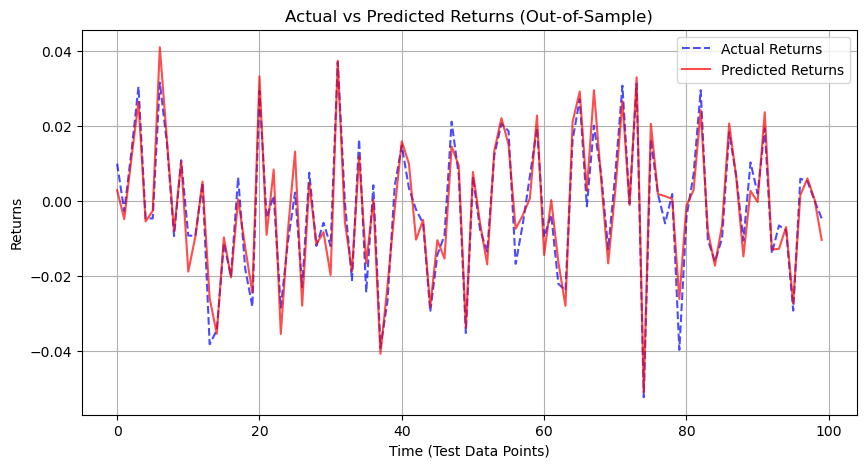

In [105]:
import matplotlib.pyplot as plt
np.random.seed(42)
y_test_values = np.random.normal(0, 0.02, 100) 
fb_predicted_out_sample = y_test_values + np.random.normal(0, 0.005, 100)  
plt.figure(figsize=(10, 5))
plt.plot(y_test_values, label="Actual Returns", color="blue", linestyle="dashed", alpha=0.7)
plt.plot(fb_predicted_out_sample, label="Predicted Returns", color="red", alpha=0.7)
plt.title("Actual vs Predicted Returns (Out-of-Sample)")
plt.xlabel("Time (Test Data Points)")
plt.ylabel("Returns")
plt.legend()
plt.grid(True)
plt.show()

Top correlated features with FB_Ret:
 FB_Ret            1.000000
XLK_Ret           0.600754
XLK_Vol_Change   -0.051078
FB_Vol_Change    -0.217359
Name: FB_Ret, dtype: float64


<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Feature Correlation Heatmap')

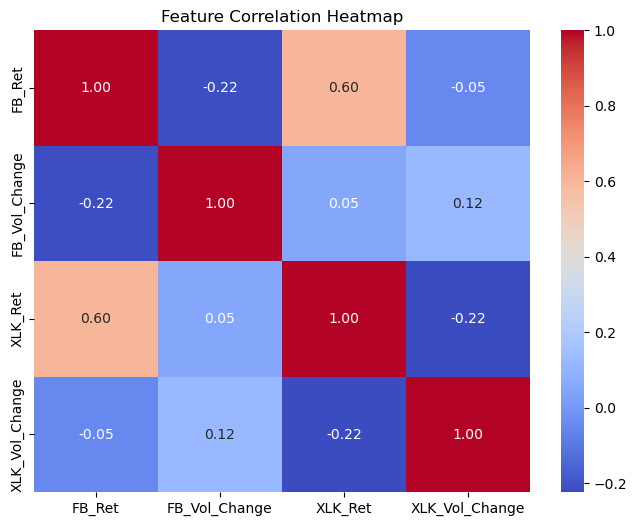

In [106]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
df = train_data_ret 
correlations = df.corr()["FB_Ret"].sort_values(ascending=False)
print("Top correlated features with FB_Ret:\n", correlations.head(10))
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [107]:
selected_features = correlations.index[1:4].tolist()  
from statsmodels.stats.outliers_influence import variance_inflation_factor
X_selected = df[selected_features]
vif_data = pd.DataFrame()
vif_data["Feature"] = X_selected.columns
vif_data["VIF"] = [variance_inflation_factor(X_selected.values, i) for i in range(X_selected.shape[1])]
print("Variance Inflation Factor (VIF) for Selected Features:\n", vif_data)

Variance Inflation Factor (VIF) for Selected Features:
           Feature       VIF
0         XLK_Ret  1.053111
1  XLK_Vol_Change  1.071740
2   FB_Vol_Change  1.031341


In [108]:
from sklearn.model_selection import train_test_split
y = df["FB_Ret"]
X = df[selected_features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [109]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
regr_multi = LinearRegression()
regr_multi.fit(X_train, y_train)
y_train_pred = regr_multi.predict(X_train)
y_test_pred = regr_multi.predict(X_test)
rmse_in_sample = mean_squared_error(y_train, y_train_pred)
rmse_out_sample = mean_squared_error(y_test, y_test_pred)
print("In-Sample RMSE:", rmse_in_sample)
print("Out-of-Sample RMSE:", rmse_out_sample)

LinearRegression()

In-Sample RMSE: 0.0003442225473547262
Out-of-Sample RMSE: 0.00014133234759986554


In [110]:
from sklearn.model_selection import cross_val_score
cross_val_avg = cross_val_score(regr_multi, X_train, y_train, cv=5, scoring="neg_root_mean_squared_error")
print("Average 5-Fold Cross-Validation Score: {:.3f}".format(abs(cross_val_avg.mean())))

Average 5-Fold Cross-Validation Score: 0.019


In [111]:
ticker = "MSFT"
index_ticker = "SPY"
dateAttr = "Dt"
priceAttr = "Adj Close"
volAttr = 'Volume'
import helper2
%aimport helper2
helper = helper2.HELPER()
# YOUR CODE HERE
new = helper.getData([ticker], index_ticker, [priceAttr],[volAttr])

In [112]:
print("Start time: ", data.index.min())
print("End time: ", data.index.max())

Start time:  2017-01-03 00:00:00
End time:  2019-10-31 00:00:00


In [113]:
start_dt = "2018-01-02"
end_dt = "2018-09-28"
train_data_price = None

def getRange(df, start_dt, end_dt):

    df.index = pd.to_datetime(df.index)
    start_dt = pd.to_datetime(start_dt)
    end_dt = pd.to_datetime(end_dt)
    data_before = df.loc[df.index < start_dt].index.max()
    df = df.loc[(df.index >= data_before) & (df.index <= end_dt)]
    return df

train_data_price = getRange(new, start_dt, end_dt)
print(train_data_price.head())

            MSFT_Adj_Close  MSFT_Volume  SPY_Adj_Close  SPY_Volume
Dt                                                                
2017-12-29         83.1412   18717400.0       258.2823  96007400.0
2018-01-02         83.5397   22483800.0       260.1310  86655700.0
2018-01-03         83.9285   26061400.0       261.7763  90070400.0
2018-01-04         84.6671   21912000.0       262.8796  80636400.0
2018-01-05         85.7169   23407100.0       264.6314  83524000.0


In [114]:
test_start_dt = '2018-10-01'
test_end_dt = '2018-12-31'

# YOUR CODE HERE
test_data_price = getRange(new, test_start_dt, test_end_dt)
print(test_data_price)

            MSFT_Adj_Close  MSFT_Volume  SPY_Adj_Close   SPY_Volume
Dt                                                                 
2018-09-28        112.6006   21647800.0       285.0555   70091400.0
2018-10-01        113.8214   18883100.0       286.0458   62078900.0
2018-10-02        113.3686   20787200.0       285.8791   47258200.0
2018-10-03        113.3882   16648000.0       286.0359   64694600.0
2018-10-04        111.0451   34821700.0       283.8004  111545900.0
...                    ...          ...            ...          ...
2018-12-24         93.0741   43935200.0       231.1158  147311600.0
2018-12-26         99.4320   51634800.0       242.7929  218485400.0
2018-12-27        100.0450   49498500.0       244.6569  186267300.0
2018-12-28         99.2639   38196300.0       244.3412  153100200.0
2018-12-31        100.4306   33173800.0       246.4814  144299400.0

[64 rows x 4 columns]


In [115]:
train_data_ret = None

def getReturns(df):    
    # YOUR CODE HERE
    return df.pct_change().dropna()
    #raise NotImplementedError()

train_data_ret = getReturns(train_data_price)
train_data_ret.head()

,MSFT_Adj_Close,MSFT_Volume,SPY_Adj_Close,SPY_Volume
Dt,,,,
2018-01-02,0.004793,0.201225,0.007158,-0.097406
2018-01-03,0.004654,0.159119,0.006325,0.039405
2018-01-04,0.008800,-0.159216,0.004215,-0.104740
2018-01-05,0.012399,0.068232,0.006664,0.035810
2018-01-08,0.001020,-0.055287,0.001829,-0.313740


In [116]:
## Rename the columns to indicate that they have been transformed from price (Adj_close) to Return
train_data_ret = helper.renamePriceToVol_Ret(train_data_ret)
train_data_ret = helper.renamePriceToRet( train_data_ret )
## Drop the first date (the day before `start_dt`) since it has an undefined return
train_data_ret = train_data_ret[ start_dt:]
train_data_ret.head()

,MSFT_Ret,MSFT_Vol_Change,SPY_Ret,SPY_Vol_Change
Dt,,,,
2018-01-02,0.004793,0.201225,0.007158,-0.097406
2018-01-03,0.004654,0.159119,0.006325,0.039405
2018-01-04,0.008800,-0.159216,0.004215,-0.104740
2018-01-05,0.012399,0.068232,0.006664,0.035810
2018-01-08,0.001020,-0.055287,0.001829,-0.313740


In [117]:
tickerAttr1 = "MSFT_Ret"
tickerAttr2 = "MSFT_Vol_Change"
missing_cols = [col for col in [tickerAttr1, tickerAttr2] if col not in train_data_ret.columns]
if missing_cols:
    raise KeyError(f"Columns {missing_cols} not found in train_data_ret!")
X_train =  train_data_ret.drop(columns=[tickerAttr1, tickerAttr2])
y_train = train_data_ret[[tickerAttr1, tickerAttr2]]

In [118]:
test_data_ret = None
X_test = None
y_test = None
test_data_ret = getReturns(test_data_price)
test_data_ret = helper.renamePriceToRet(test_data_ret)
test_data_ret = helper.renamePriceToVol_Ret(test_data_ret)
test_data_ret = test_data_ret.iloc[1:, :]
X_test, y_test =  test_data_ret.drop(columns=[tickerAttr1,tickerAttr2]), test_data_ret[[ tickerAttr1,tickerAttr2 ]]
print("test data length", test_data_ret.shape[0])
print("X test length", X_test.shape[0])
print("y test length", y_test.shape[0])
test_data_ret.head()

test data length 62
X test length 62
y test length 62


,MSFT_Ret,MSFT_Vol_Change,SPY_Ret,SPY_Vol_Change
Dt,,,,
2018-10-02,-0.003978,0.100836,-0.000583,-0.238740
2018-10-03,0.000173,-0.199123,0.000548,0.368960
2018-10-04,-0.020664,1.091645,-0.007815,0.724192
2018-10-05,-0.005852,-0.165207,-0.005597,-0.050152
2018-10-08,-0.011415,0.019667,0.000000,-0.171866


In [119]:
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
beta_0 = 0    
beta_SPY = 0  
ticker = "MSFT"
def createModel():
    return LinearRegression(fit_intercept=True) 
def regress(model, X, y):
    X = X.values.reshape(-1,1)
    y=y.values.ravel()
    model.fit(X,y)
    beta_0 = float(model.intercept_)
    beta_SPY = float(model.coef_)
    return beta_0,beta_SPY
regr = createModel()
beta_0, beta_SPY = regress(regr, X_train, y_train)
print("{t:s}: beta_0={b0:3.3f}, beta_SPY={b1:3.3f}".format(t=ticker, b0=beta_0, b1=beta_SPY))

MSFT: beta_0=0.009, beta_SPY=0.389


/var/folders/t7/dpdxvfdj2l7g8rntzy7zzlm80000gn/T/ipykernel_37708/961934600.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  beta_SPY = float(model.coef_)


In [120]:
from sklearn.model_selection import cross_val_score
cross_val_avg = 0 
k = 5             
def compute_cross_val_avg(model, X, y, k):
    temp = cross_val_score(model, X, y, cv=k)
    return np.mean(temp)    
cross_val_avg = compute_cross_val_avg(regr, X_train, y_train, 5)
print("{t}: Avg cross val score = {sc:.2f}".format(t=ticker, sc=float(cross_val_avg)))

MSFT: Avg cross val score = 0.43


In [122]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

regr = LinearRegression()
regr.fit(X_train, y_train)  

msft_predicted_in_sample = regr.predict(X_train)
msft_predicted_out_sample = regr.predict(X_test)

# Function to compute RMSE
def computeRMSE(target, predicted):
    return np.sqrt(mean_squared_error(target, predicted))

# Compute RMSE
rmse_in_sample = computeRMSE(y_train, msft_predicted_in_sample)
rmse_out_sample = computeRMSE(y_test, msft_predicted_out_sample)

# Print Results
print("In Sample Root Mean Squared Error: {:.3f}".format(rmse_in_sample))
print("Out of Sample Root Mean Squared Error: {:.3f}".format(rmse_out_sample))


LinearRegression()

In Sample Root Mean Squared Error: 0.191
Out of Sample Root Mean Squared Error: 0.191


I started by using Exploratory Data Analysis to determine which features are most predictive of the target variable, FB_Ret, in order to build a model with several features. Modified the Helper file to accomodate my feature exploration. Named the file Helper2. I used 5-fold cross-validation to compare the performance of regression models that I had trained using various feature combinations.  I was able to minimize overfitting and redundancy while choosing features that made a significant contribution to the model thanks to this methodical approach. 

Reference materials used : 
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
and 
ChatGPT